# Corn Tassel Detection Using Computer Vision Techniques

by Amber Benbow

Now that we have a better idea of what color spaces are and how they make up an image, we would like to use that information to train an unsupervised machine learning algorithm or two. First we must extract the pixel values from the images. 

## Part 2: Unsupervised Learning Methods

#### Preparing an image array

In [3]:
#importing common libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = [12, 12]

(2250, 3000, 3)


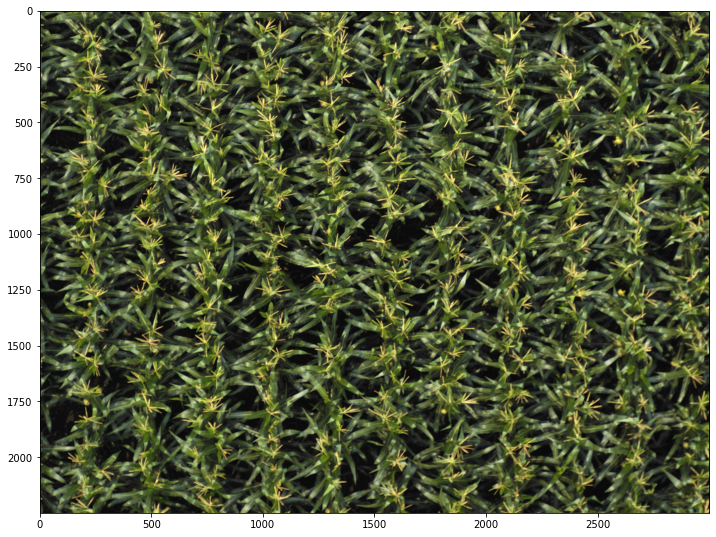

In [5]:
#opening a single image from the training set to get its shape and display it
demo_img = cv2.imread('/Users/petri142/CornTasselingProject/train/train/images/Img_07152021_10.jpg')

#convert it from BGR to RGB
demo_img_color = cv2.cvtColor(demo_img, cv2.COLOR_BGR2RGB)

#inspect the shape of the image
print(demo_img_color.shape)

#display the image
plt.imshow(demo_img_color)

In [7]:
from skimage.color import rgb2hsv

#change directory
os.chdir('/Users/petri142/CornTasselingProject/train/train/images')

#create giant list by extracting the RGB and HSV pixel values from every image
img_arr = []
for pic in glob.glob('*.jpg'): 
    im = cv2.imread(pic) #open image
    color_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #convert from BGR to RGB
    rgb_img = color_img/255 #normalize RGB
    hsv_img = rgb2hsv(rgb_img) #convert RGB to HSV
    combo_img = cv2.addWeighted(rgb_img, 1, hsv_img, 1, 0) #combine the images into one array, giving equal weight
    img_arr.append(combo_img) #append to list

In [8]:
#checking that the image list values look correct
print(img_arr[:1])

#convert to an array for training
img_arr = np.array(img_arr)

[array([[[0.59750446, 0.46531863, 0.25098039],
        [0.58921569, 0.41536831, 0.28627451],
        [0.52388592, 0.41740196, 0.34509804],
        ...,
        [0.45784314, 0.92533741, 0.41568627],
        [0.43757503, 0.9629085 , 0.37254902],
        [0.42973189, 0.9745098 , 0.35686275]],

       [[0.64064171, 0.42051984, 0.3372549 ],
        [0.58449198, 0.41740196, 0.36078431],
        [0.55525847, 0.41603641, 0.40784314],
        ...,
        [0.45784314, 0.92533741, 0.41568627],
        [0.44468085, 0.93011013, 0.38823529],
        [0.43365346, 0.96857222, 0.36470588]],

       [[0.64803922, 0.39622926, 0.40392157],
        [0.58948307, 0.41651187, 0.42352941],
        [0.56503268, 0.43848039, 0.4627451 ],
        ...,
        [0.44075928, 0.93513072, 0.38039216],
        [0.42766411, 0.94313725, 0.35294118],
        [0.41982097, 0.95579323, 0.3372549 ]],

       ...,

       [[0.54050245, 0.70939112, 0.61960784],
        [0.55588235, 0.73166964, 0.64313725],
        [0.5872549 , 

In [9]:
#checking min/max for the array
max_v = img_arr.max()
min_v = img_arr.min()


min_v, max_v

(0.0, 2.0)

Due to weighting of the combined image, the max value is greater than 1. However, it is important that the numbers be closely related in scale. A range of 0-2 is better than 0-255. The RBG values going up to 255 when all of HSV values are 0-1 would heavily skew the results away from HSV.

In [10]:
#looking to see what the shape of the mega array is
print(img_arr.shape)

#isolating only one image's shape
print(img_arr[9:10].shape)

(34, 2250, 3000, 3)
(1, 2250, 3000, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


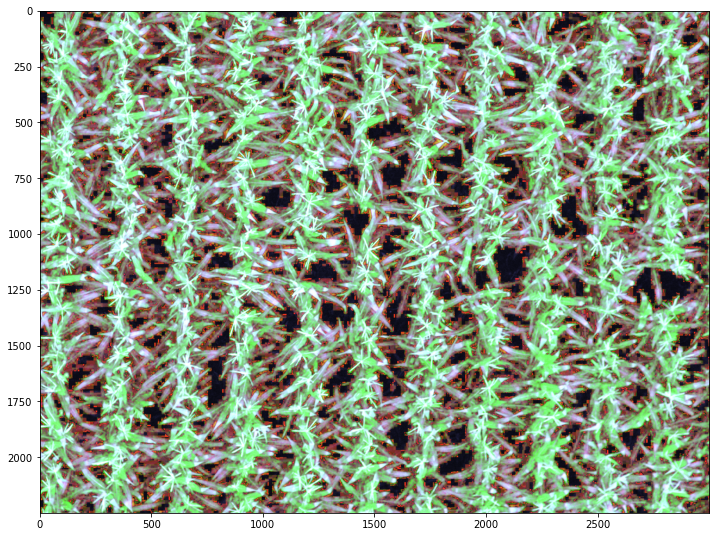

In [11]:
#slice one image from the array
new_img = img_arr[8:9,:,:,:]
new_img = new_img.reshape(demo_img_color.shape)
plt.imshow(new_img)

A single image from the drone set contains 3000 pixels X 2250 pixels = 6,750,000 (6.7 mil) pixels. In order to determine which features within our training set is most valuable, we will use Principal Component Analysis. In order to train the algorithm we will need to reshape it to a 2D array. 

In [12]:
#reshape to number of features which will be used in PCA
img_arr = img_arr.reshape((-1,6))
print(img_arr.shape)

(114750000, 6)


### Principal Component Analysis 
#### PCA

This is an unsupervised machine learning algorithm that is used to reduce the dimensionality of a dataset. It searches for features that display the most variability. This variability typically indicates that the feature has more influence on the dataset. Limiting the dataset to these key features is the best way to find out what would be ideal for clustering using another algorithm such as K-Means.

In [13]:
#reducing the six features to the three most important

from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(img_arr)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2','PC 3'])

In [14]:
#Identifying the most important features from our training set

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['R','B','G','H','S','V']

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

0  1
0  PC1  B
1  PC2  B
2  PC3  R

In [15]:
#look at the bottom of the PCA's
principalDf.tail()

PC 1      PC 2      PC 3
114749995  0.142431 -0.251702  0.052353
114749996  0.193797 -0.356006  0.074141
114749997  0.202557 -0.310065  0.061267
114749998  0.225792 -0.298747  0.057591
114749999  0.230021 -0.319073  0.065848

Now that we know the features which contribute the most to our analysis, we will loop through the images and extract only features.

*Please note that the mega array to train K-Means was abandoned due to timing issues. In the future, I would use the mega array to find the ideal cluster centers, then populate those ideal centers as the clusters for the individual images.*

In [17]:
#after doing PCA, recreate the array to get only the most important features 

#change directory
os.chdir('/Users/petri142/CornTasselingProject/train/train/images')

#create giant list by extracting only the rgb pixel values from every image
rgb_img_arr = []
for pic in glob.glob('*.jpg'): 
    im = cv2.imread(pic) #open image
    color_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #convert from BGR to RGB
    rgb_img = color_img/255
    rgb_img_arr.append(rgb_img) #append to list

In [18]:
#checking that the image list values look correct
print(rgb_img_arr[:1])

#convert to an array for training
rgb_img_arr = np.array(rgb_img_arr)

[array([[[0.08235294, 0.12156863, 0.1254902 ],
        [0.10588235, 0.14509804, 0.14117647],
        [0.14509804, 0.18823529, 0.15686275],
        ...,
        [0.20784314, 0.30196078, 0.11372549],
        [0.19607843, 0.28235294, 0.09019608],
        [0.18823529, 0.2745098 , 0.08235294]],

       [[0.1254902 , 0.16470588, 0.16862745],
        [0.14509804, 0.18823529, 0.17254902],
        [0.17647059, 0.21960784, 0.18823529],
        ...,
        [0.20784314, 0.30196078, 0.11372549],
        [0.2       , 0.28627451, 0.10196078],
        [0.19215686, 0.27843137, 0.08627451]],

       [[0.16470588, 0.20392157, 0.2       ],
        [0.18039216, 0.22352941, 0.2       ],
        [0.20392157, 0.25098039, 0.21176471],
        ...,
        [0.19607843, 0.28235294, 0.09803922],
        [0.19215686, 0.26666667, 0.08627451],
        [0.18431373, 0.25882353, 0.07843137]],

       ...,

       [[0.36862745, 0.37254902, 0.24705882],
        [0.38431373, 0.38823529, 0.25490196],
        [0.41568627, 

### K-means

This algorithm is an unsupervised machine learning method which divides data into centroid clusters. These clusters then become the parts which are segmented from the image.

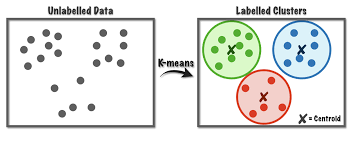

Image from: https://towardsdatascience.com/k-means-a-complete-introduction-1702af9cd8c

In [19]:
from cv2 import kmeans
import tensorflow as tf

(2250, 3000, 3)


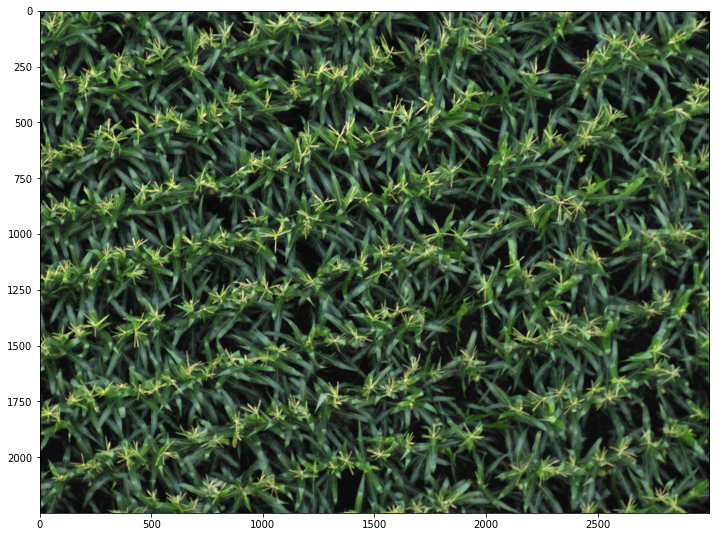

In [20]:
#set working directory
os.chdir('/Users/petri142/CornTasselingProject/train/train/images')

#opening a single image from the training set to get its shape and display it
img = cv2.imread('Img_07152021_24.jpg')
img_name = 'Img_07152021_24'

#convert it from BGR to RGB
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#inspect the shape of the image
print(img_color.shape)

#display the image
plt.imshow(img_color)

In [21]:
# define stopping criteria (global for both)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.2)

In [22]:
#create an array to train the Kmeans algorithm with
kmeans_img = img_color.reshape((-1,3))
kmeans_arr = np.float32(kmeans_img)

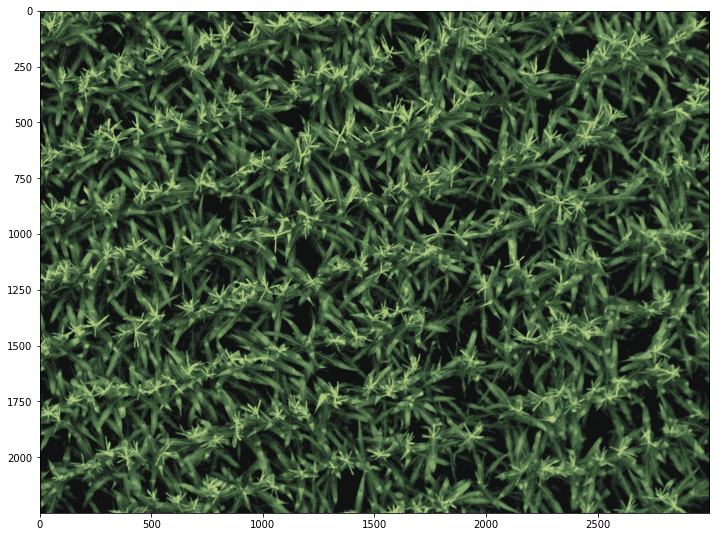

In [23]:
k = 8
_, labels, (centers) = cv2.kmeans(kmeans_arr, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

#convert back to 8 bit values
centers = np.uint8(centers)

#flatten the labels array
label_names = labels
labels = labels.flatten()

#convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

#reshape back to the original image dimension
segmented_image = segmented_image.reshape(img_color.shape)

#view the image segmented by Kmeans
plt.imshow(segmented_image)

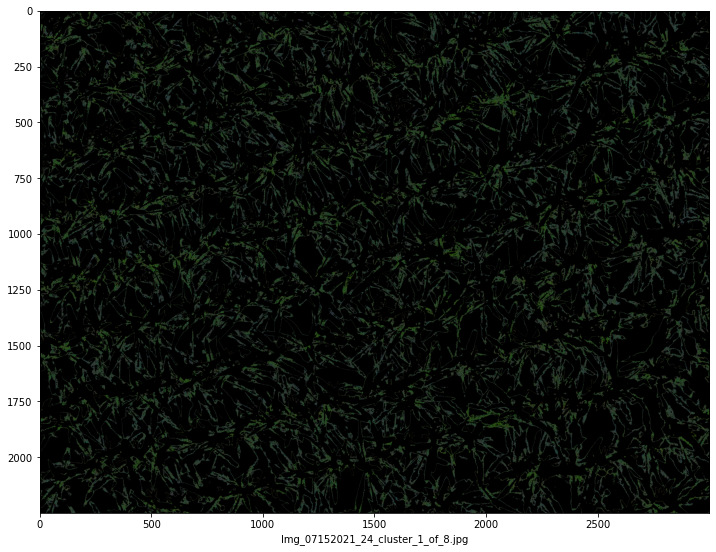

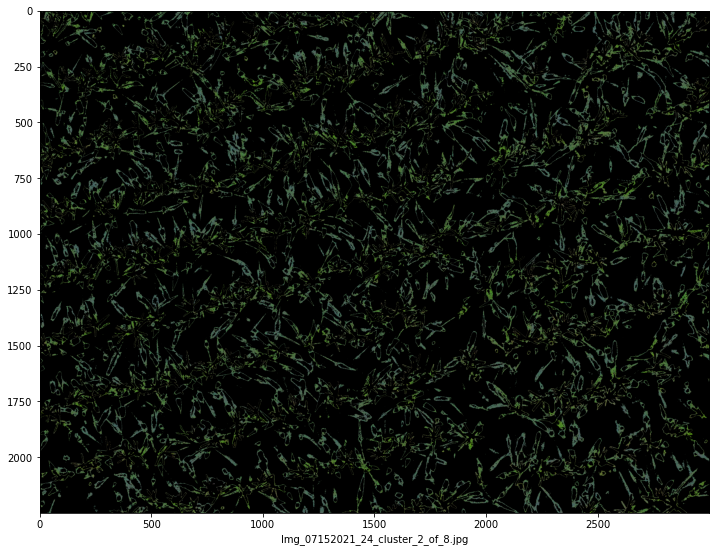

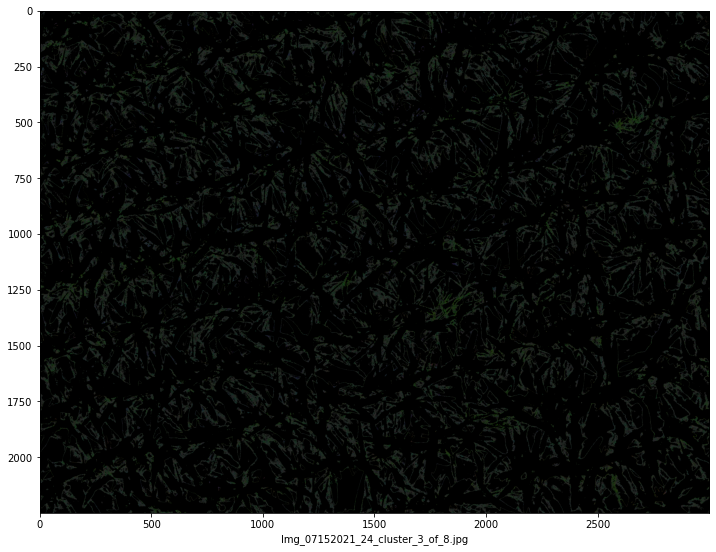

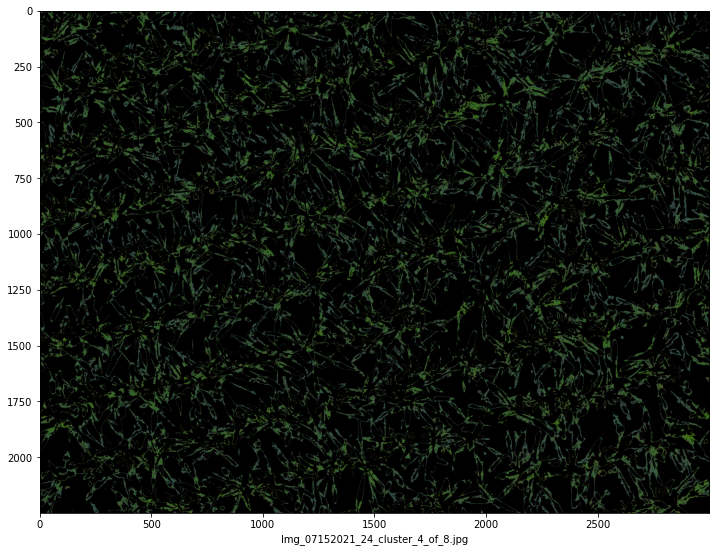

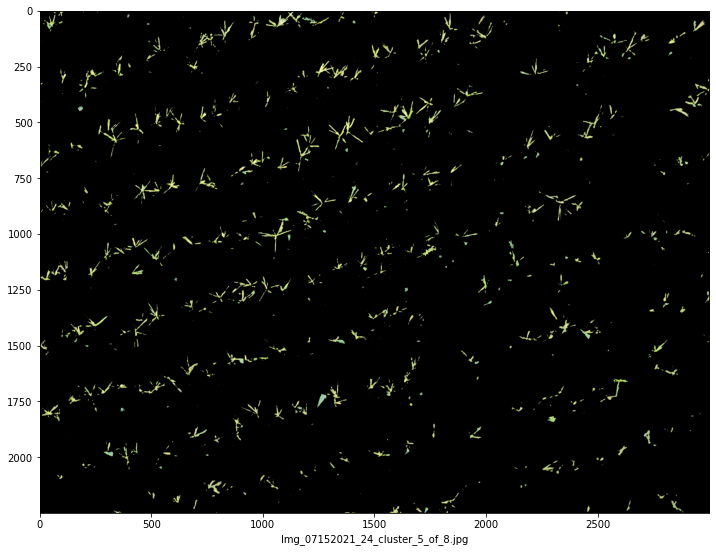

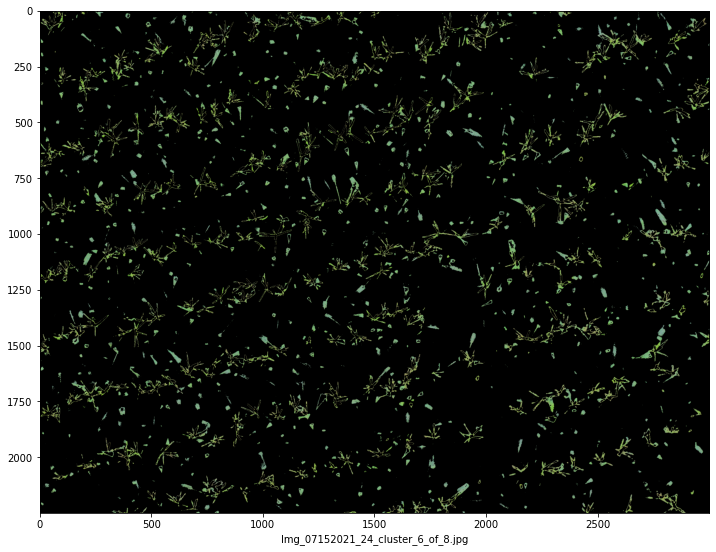

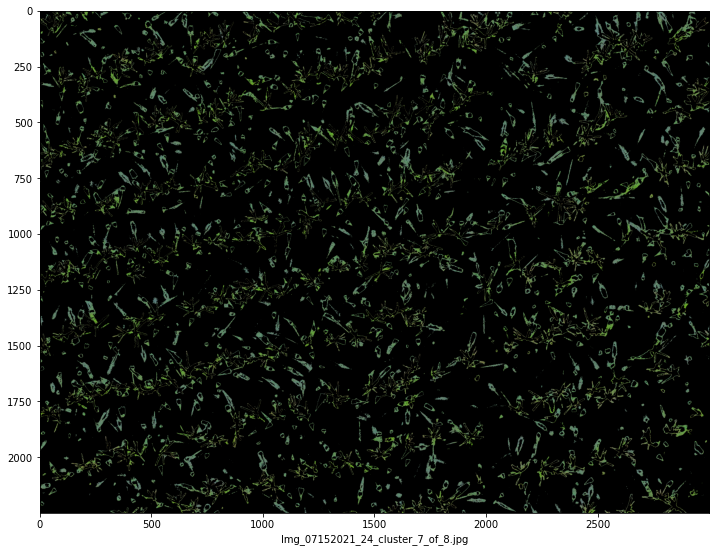

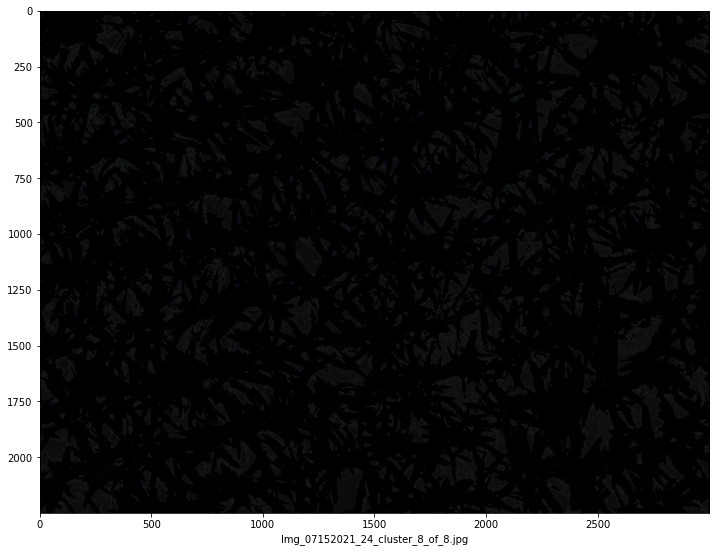

In [24]:
#save Kmeans images to special folder
os.chdir('/Users/petri142/CornTasselingProject/train/kmeans_cluster_images')

#a list to iterate over the clusters
n_clusters = [1,2,3,4,5,6,7,8]

#for each cluster, make a mask of that cluster only
#show it and save it to an image
for cluster in range(len(n_clusters)):
    #make mask a copy of the image
    mask = np.copy(img_color)

    #convert to the shape of a vector of pixel values
    mask = mask.reshape((-1, 3))

    #cluster to keep
    mask[labels != cluster] = [0,0,0]

    #shape into an image
    mask = mask.reshape(img_color.shape)
    
    #create new image name
    new_name = img_name + '_cluster_' + str(cluster+1) + '_of_' + str(k) + '.jpg'

    #show the image
    plt.imshow(mask)
    plt.xlabel(new_name)
    plt.show()
    
    #save the cluster mask with new name
    tf.keras.utils.save_img(new_name, mask, file_format='jpeg', scale=True)